# Classical Methods

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

import torch

In [2]:
SAVE_PATH = "./"

TRAIN_TEST_SPLIT = (0.8, 0.1) # remaining parts will be test
DIRECTORY_PATH = "/home/mericdemirors/Desktop/TUD_lectures/DLMI/project/project_capsule_dataset"

THRESHOLD = 0.5 # predictions bigger than threshold will be counted as bleeding prediction, and lower ones will be healthy prediction

## Decision Function

In [3]:
class BleedDataset(Dataset):
    def __init__(self, root_dir, image_read_func="RGB"):
        self.root_dir = root_dir
        self.bleeding_dir = os.path.join(root_dir, "bleeding")
        self.healthy_dir = os.path.join(root_dir, "healthy")

        # get image paths
        self.x = [os.path.join(self.bleeding_dir, p) for p in os.listdir(self.bleeding_dir)] + [os.path.join(self.healthy_dir, p) for p in os.listdir(self.healthy_dir)]
        
        # get image labels, bleeding=1, healthy=0
        self.y = [1 for _ in os.listdir(self.bleeding_dir)] + [0 for _ in os.listdir(self.healthy_dir)]
        self.num_samples = len(os.listdir(self.bleeding_dir)) + len(os.listdir(self.healthy_dir))

        # set up the function to use for image reading
        # different reading functions can be written and used with this structure
        if image_read_func == "RGB":
            self.image_read_function = self.read_RGB
        elif image_read_func == "gray":
            self.image_read_function = self.read_gray
        else:
            print("Wrong image_read_func parameter")

    def __len__(self):
        return self.num_samples

    def read_RGB(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = [0,0,0] # painting the upper left corner if there is a gray square
        image[:31, 452:] = [0,0,0] # painting the upper right corner if there is white text parts
        image = np.transpose(image, [2,0,1]) # adjust the axises into the pytorch dimensions of [B, C, W, H]

        return image, label
    
    def read_gray(self, idx):
        path = self.x[idx]
        label = self.y[idx]
        
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = image[32:544, 32:544] # cropping image to get rid of the black borders
        image[:48,:48] = 0 # painting the upper left corner if there is a gray square
        image[:31, 452:] = 0 # painting the upper right corner if there is white text parts
        image = image[np.newaxis, ...] # adjust the axises into the pytorch dimensions of [B, C, W, H]
        
        return image, label

    def __getitem__(self, idx):
        image, label = self.image_read_function(idx)
        return image, label

In [4]:
### ---|---|---|---|---|---|---|---|---|---|--- DATASET SPLIT ---|---|---|---|---|---|---|---|---|---|--- ###
dataset = BleedDataset(DIRECTORY_PATH, image_read_func="RGB")

train_size = int(TRAIN_TEST_SPLIT[0] * len(dataset))
test_size = int(TRAIN_TEST_SPLIT[1] * len(dataset))
validation_size = len(dataset) - train_size - test_size

torch.manual_seed(0) # setting the seed to 0 so dataset split is same for every run
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_validation_dataset = ConcatDataset([train_dataset, validation_dataset])

train_validation_dataloader = DataLoader(train_validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
labels = [l.item() for (_,l) in tqdm(train_validation_dataloader)]

100%|██████████| 6187/6187 [00:38<00:00, 162.04it/s]


## Creating Decision Function

In [6]:
def torch_tensor_to_RGB_numpy(image):
    image = np.transpose(image, (1, 2, 0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def function(image, window_size=18, red_multiplier=5.5, green_multiplier=-9.5, blue_multiplier=-0.5, percentile=2):
    image_rgb = image.astype(np.float32)

    redness_score = image_rgb[:, :, 0] * red_multiplier + image_rgb[:, :, 1] * green_multiplier + image_rgb[:, :, 2] * blue_multiplier

    # remove found spots outside the image
    mask = cv2.imread("mask_meric.png", cv2.IMREAD_GRAYSCALE)

    redness_score = redness_score - np.abs((mask * np.min(redness_score)))

    # Find the top % reddish pixel values
    threshold = np.percentile(redness_score, 100-percentile)
    high_red_indices = np.where(redness_score >= threshold)

    # Initialize variables for the best score and coordinates
    max_score = -np.inf
    best_coords = (0, 0)

    # Calculate window scores only around high redness indices
    h, w = redness_score.shape
    for row, column in zip(*high_red_indices):
        # Define the top-left corner of the window
        top_left_row = max(0, row - window_size // 2)
        top_left_column = max(0, column - window_size // 2)

        # Define the bottom-right corner of the window
        bottom_right_row = min(h, top_left_row + window_size)
        bottom_right_column = min(w, top_left_column + window_size)

        # Extract the window and calculate its redness score
        window = redness_score[top_left_row:bottom_right_row, top_left_column:bottom_right_column]
        score = np.sum(window)

        if score > max_score:
            max_score = score
            best_coords = (row, column)
    
    # Highlight the most reddish area on the image
    image_rgb = image_rgb.astype(np.uint8)
    
    left_upper_column_row = [max(0, best_coords[1] - window_size//2), max(0, best_coords[0] - window_size//2)]
    right_lower_column_row = [min(w, best_coords[1] + window_size//2), min(h, best_coords[0] + window_size//2)]
    cv2.rectangle(image_rgb, left_upper_column_row, right_lower_column_row, (0, 255, 0), 2)
    
    return max_score

decision_function = function

In [7]:
def predict(dataloader = train_validation_dataloader, parameters = [18, 5.5, -9.5, -0.5, 0.0001], stop=10000):
    predictions = []
    for e, (image, _) in tqdm(enumerate(dataloader)):
        if e == stop:
            break
        np_image = image.detach().cpu().numpy()[0]
        np_image = torch_tensor_to_RGB_numpy(np_image)
        decision = decision_function(np_image, *parameters)
        predictions.append(decision)
    return predictions

def plot_metrics(predictions, n=100):
    def calculate_metric_scores(THRESHOLD):
        detections = np.array(predictions)
        detections[detections < THRESHOLD] = 0
        detections[detections >= THRESHOLD] = 1
        np.sum(detections == labels[:len(detections)])

        # Compute Precision, Recall, F1-Score
        precision = precision_score(labels[:(len(detections))], detections)
        recall = recall_score(labels[:(len(detections))], detections)
        f1 = f1_score(labels[:(len(detections))], detections)

        # Compute Precision-Recall Curve and Area Under Precision-Recall Curve (AUC-PR)
        precisions, recalls, _ = precision_recall_curve(labels[:(len(detections))], detections)
        auc_pr = auc(recalls, precisions)

        return precision, recall, f1, float(auc_pr)

    precisions = []
    recalls = []
    f1s = []
    auc_prs = []
    equal_splitter_thresholds = np.quantile(predictions, np.linspace(0, 1, n))  # 10 equal parts
    for th in equal_splitter_thresholds:
        scores = calculate_metric_scores(th)
        # formatted_scores = tuple(round(value, 2) for value in scores)
        # print(f"th: {th:.2f}, precision: {formatted_scores[0]}, recall: {formatted_scores[1]}, f1: {formatted_scores[2]}, auc: {formatted_scores[3]}")
        precisions.append(scores[0])
        recalls.append(scores[1])
        f1s.append(scores[2])
        auc_prs.append(scores[3])

    # Plotting the metrics
    plt.figure(figsize=(15, 8))

    # Plot each metric with a label

    plt.plot(range(len(equal_splitter_thresholds)), precisions, marker='o', label='Precision', linestyle='-')
    plt.plot(range(len(equal_splitter_thresholds)), recalls, marker='s', label='Recall', linestyle='--')
    plt.plot(range(len(equal_splitter_thresholds)), f1s, marker='^', label='F1-Score', linestyle='-.')
    plt.plot(range(len(equal_splitter_thresholds)), auc_prs, marker='d', label='AUC-PR', linestyle=':')

    # Add labels and title
    plt.xlabel('Thresholds')
    plt.ylabel('Metrics')
    plt.title('Metrics vs Thresholds')

    # Add grid and legend
    plt.grid(alpha=0.5)
    plt.legend()

    # Set x-axis ticks to be the threshold values
    tick_labels = [round(x, 2) for x in equal_splitter_thresholds]
    plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels, rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()

6187it [01:32, 66.76it/s]


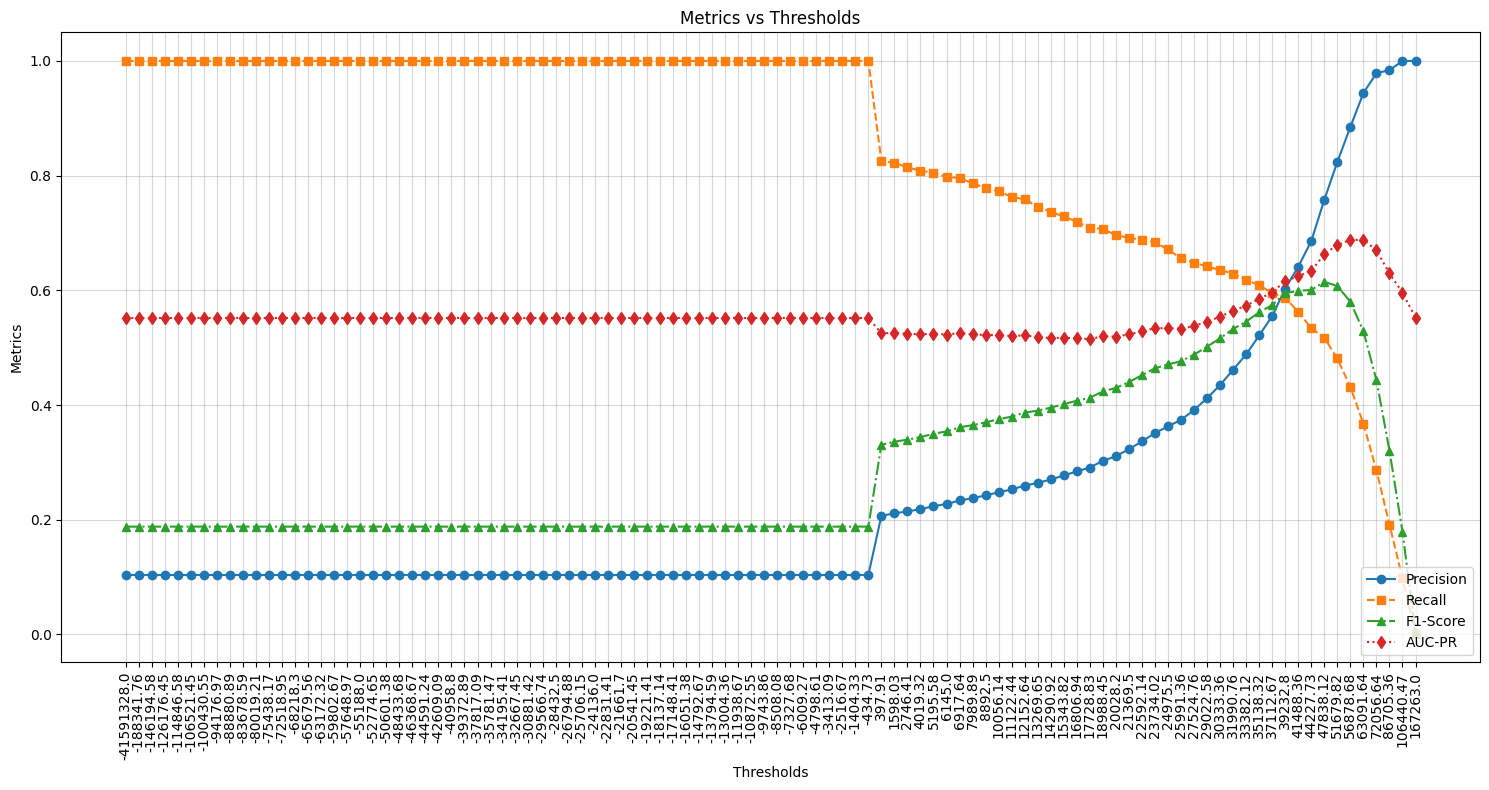

In [8]:
parameters = [18, 5.5, -9.5, -0.5, 0.0001]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

6187it [01:33, 66.02it/s]


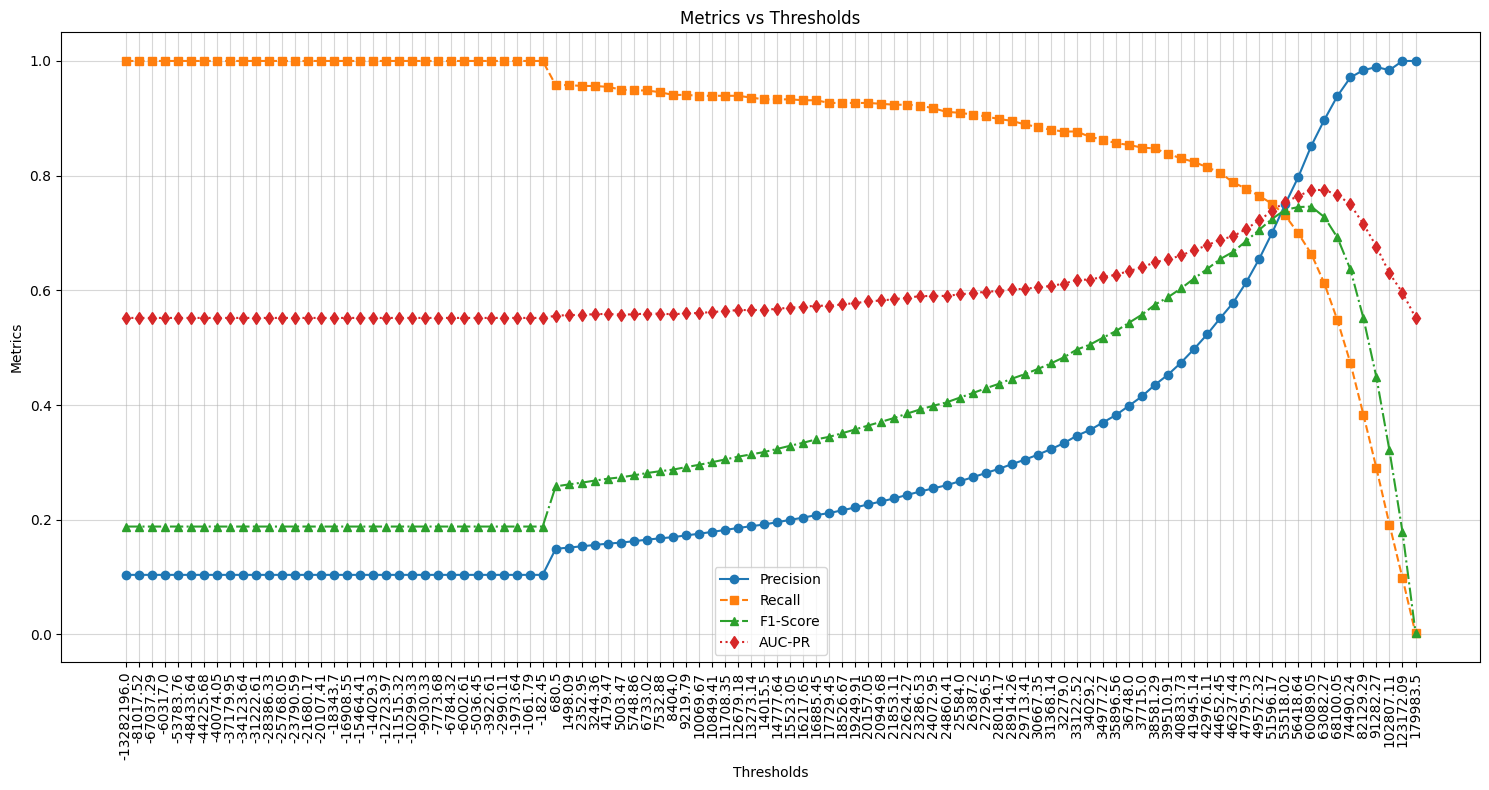

In [9]:
parameters = [18, 5.5, -9.5, -0.5, 0.01]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

6187it [03:25, 30.09it/s]


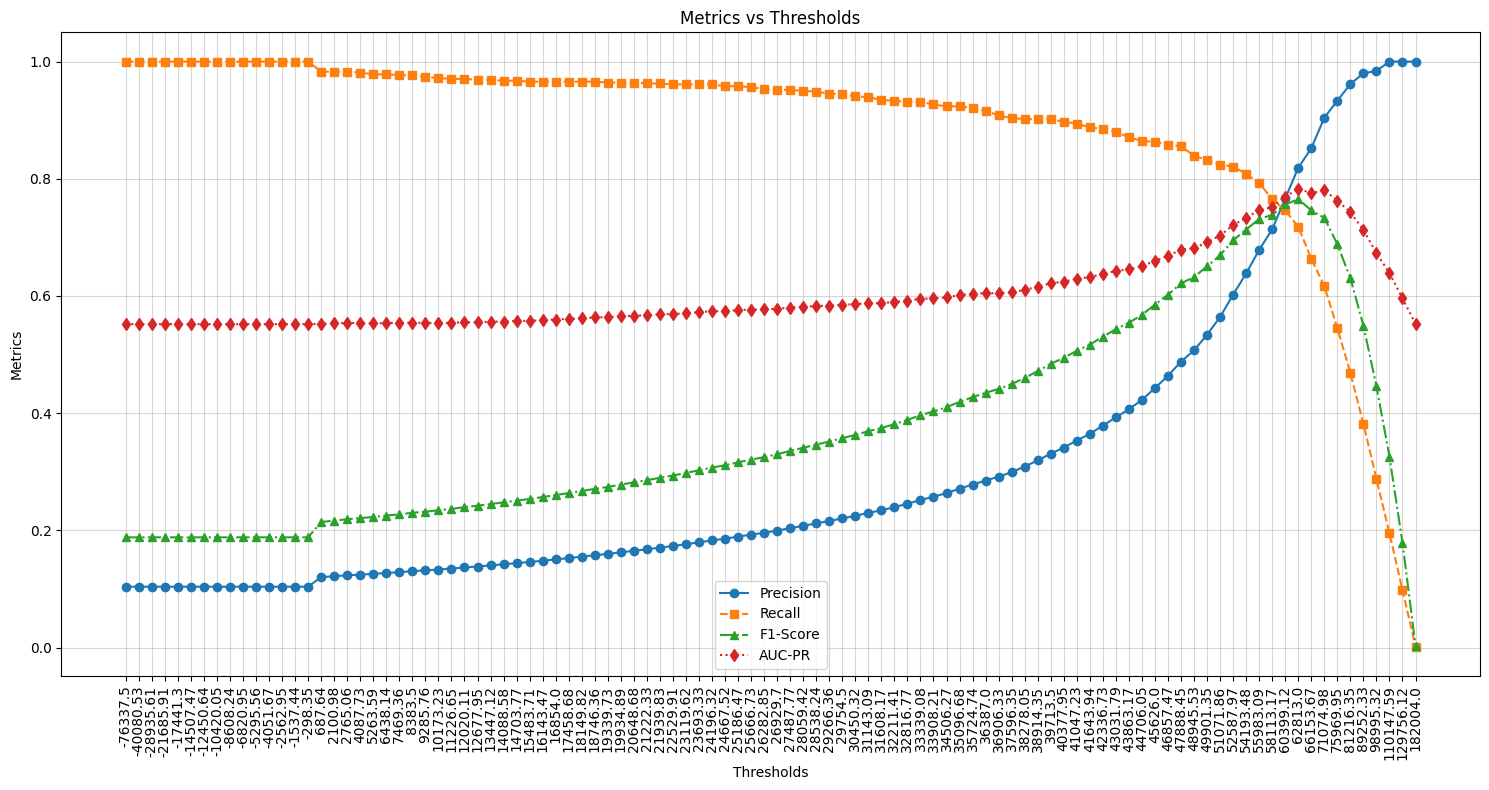

In [10]:
parameters = [18, 5.5, -9.5, -0.5, 1]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

6187it [04:55, 20.93it/s]


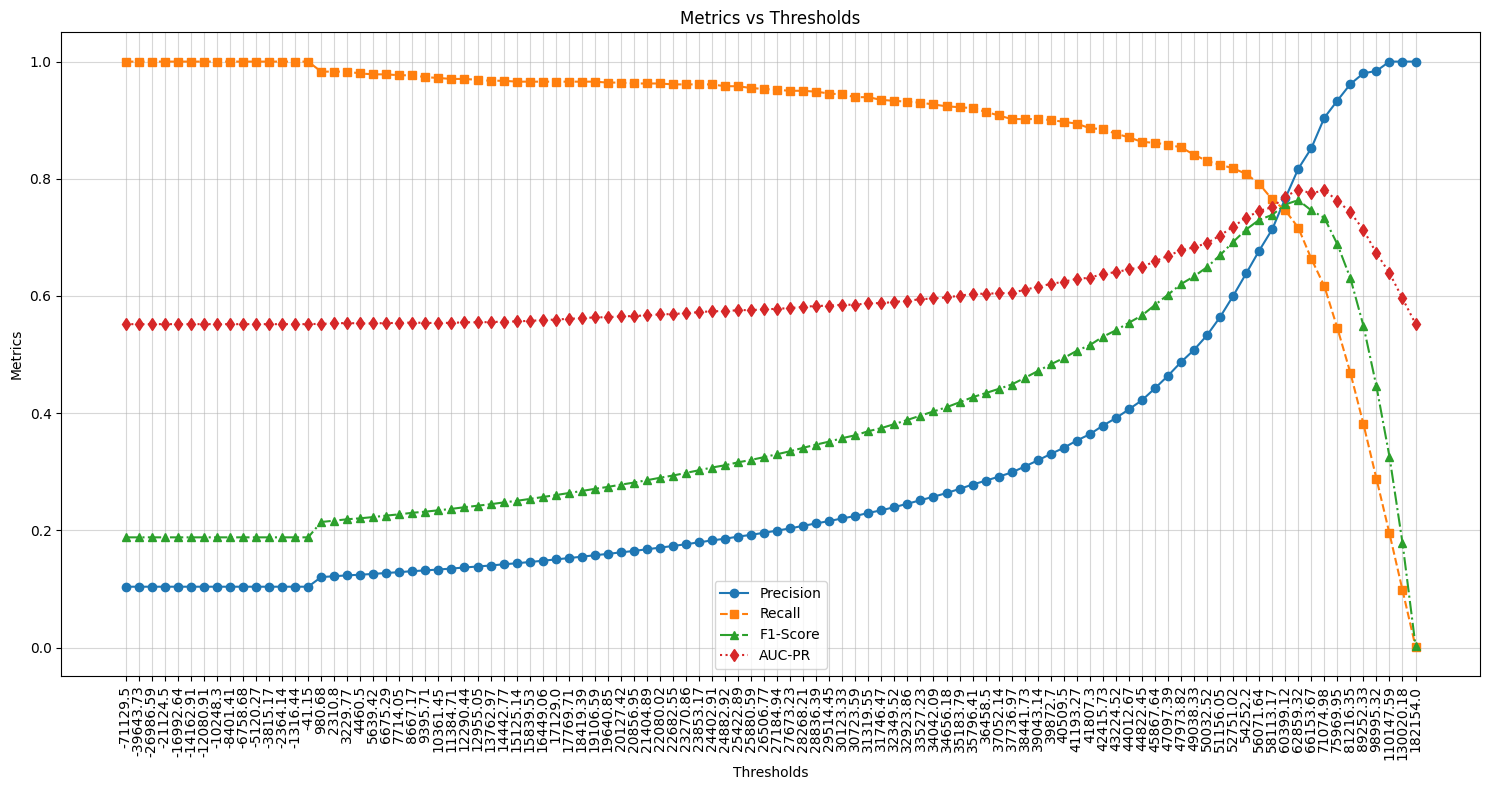

In [15]:
parameters = [18, 5.5, -9.5, -0.5, 2]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

6187it [16:17,  6.33it/s]


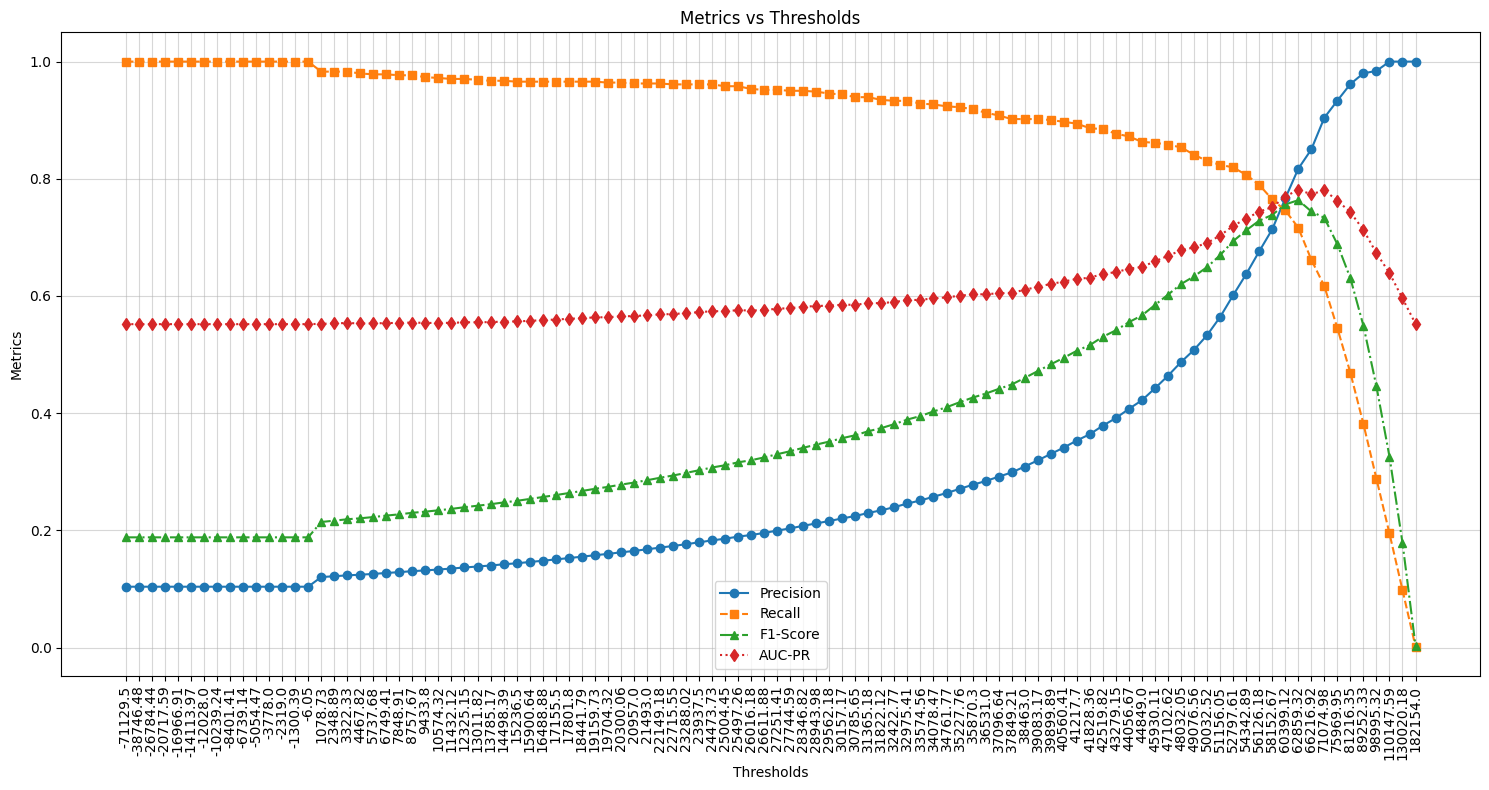

In [8]:
parameters = [18, 5.5, -9.5, -0.5, 4]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

6187it [36:55,  2.79it/s]


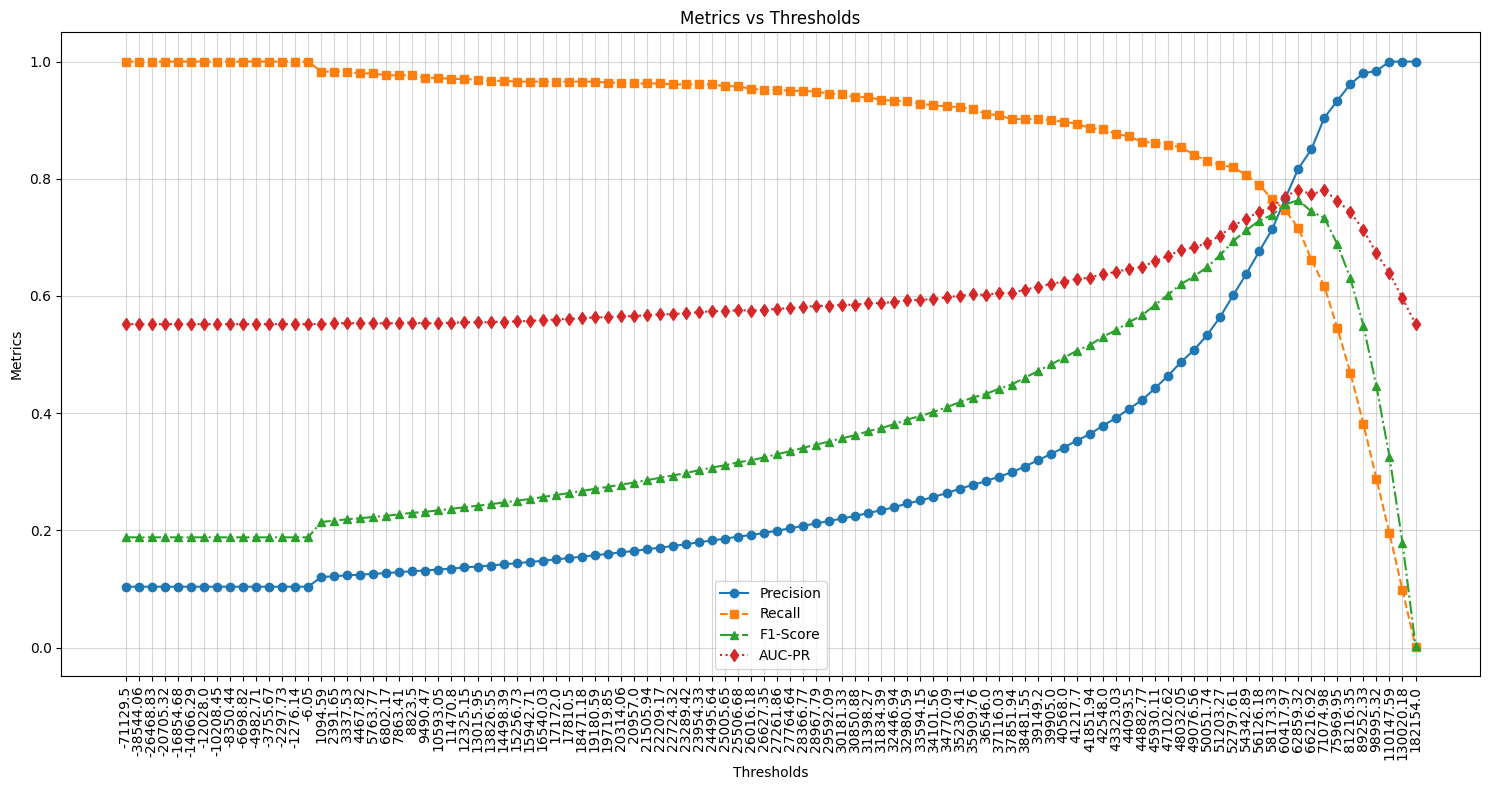

In [9]:
parameters = [18, 5.5, -9.5, -0.5, 10]
p = predict(dataloader=train_validation_dataloader, parameters=parameters)
plot_metrics(p)

# Test Scores

In [10]:
labels = [l.item() for (_,l) in tqdm(test_dataloader)]

100%|██████████| 687/687 [00:04<00:00, 166.44it/s]


In [12]:
parameters = [18, 5.5, -9.5, -0.5, 10]
p = predict(dataloader=test_dataloader, parameters=parameters)

687it [04:24,  2.60it/s]


In [13]:
detections = np.array(p)
THRESHOLD = 62859
detections[detections < THRESHOLD] = 0
detections[detections >= THRESHOLD] = 1
np.sum(detections == labels[:len(detections)])

# Compute Precision, Recall, F1-Score
precision = precision_score(labels[:(len(detections))], detections)
recall = recall_score(labels[:(len(detections))], detections)
f1 = f1_score(labels[:(len(detections))], detections)

# Compute Precision-Recall Curve and Area Under Precision-Recall Curve (AUC-PR)
precisions, recalls, _ = precision_recall_curve(labels[:(len(detections))], detections)
auc_pr = auc(recalls, precisions)

print(precision)
print(recall)
print(f1)
print(float(auc_pr))

0.7857142857142857
0.6197183098591549
0.6929133858267716
0.7223669528085543
